In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from scipy.fftpack import rfft,rfftfreq,irfft, fft
import datetime
from scipy.optimize import curve_fit,leastsq
from statsmodels.tsa.seasonal import seasonal_decompose


In [3]:
gold_data = pd.read_csv('gold_data.csv')
print(gold_data.shape)
gold_data.drop(['Vol.'],axis=1,inplace=True)
gold_data.head()

(2561, 7)


,Date,Price,Open,High,Low,Change %
0,11/19/2023,"1,996.30","1,983.35","2,009.75","1,967.45",0.58%
1,11/12/2023,"1,984.70","1,942.95","1,996.40","1,935.75",2.43%
2,11/05/2023,"1,937.70","1,999.40","2,000.10","1,936.90",-3.08%
3,10/29/2023,"1,999.20","2,013.50","2,017.70","1,978.20",0.04%
4,10/22/2023,"1,998.50","1,987.70","2,019.70","1,964.60",0.21%


In [4]:
#All data are type 'object' so first we need to convert the numerical ones to 'float' and the dates to 'datetime'.
gold_data.dtypes
cols = ['Price','Open','High','Low','Change %']
#We first need to remove the commas to the numbers.
for col in cols:
    for i in range(0,gold_data.shape[0]):
        gold_data.loc[i,col] = gold_data.loc[i,col].replace(',','')
        gold_data.loc[i,col] = gold_data.loc[i,col].strip(' %')

    gold_data[col] = gold_data[col].astype('float',copy=False)


In [5]:
gold_data.tail()

,Date,Price,Open,High,Low,Change %
2556,02/02/1975,177.3,179.1,179.7,174.1,-0.39
2557,01/26/1975,178.0,180.0,180.7,175.4,-0.84
2558,01/19/1975,179.5,173.6,180.0,173.6,4.30
2559,01/12/1975,172.1,181.0,181.0,172.1,-5.07
2560,01/05/1975,181.3,172.0,181.3,167.5,3.78


In [6]:
#Dates to datetime:
for i in range(0,gold_data.shape[0]):
    gold_data.loc[i,'Date'] = datetime.datetime.strptime(gold_data.loc[i,'Date'],'%m/%d/%Y').date()#WTF hermano

In [7]:
def MA(data,period):
    n = len(data) - period + 1
    result = np.linspace(0,0,n)
    for i in range(0,n):
        sum = 0
        for k in range(i,i+period):
            sum += data[k]
        result[i] = sum/period
    return result
def my_fft_week(data):
    X = fft(data.values)
    N = len(X)
    n = np.arange(0,N)
    sr = 1/(24*60*60*7)
    Tot = N/sr
    freq = n/Tot
    #Frequency with half the time.
    n_oneside = N//2
    f_oneside = freq[:n_oneside]
    t_week = (1/f_oneside)/(60*60*24*7)
    return n_oneside,t_week,X,f_oneside
Tot = 2561*(3600*24*7)#This number is hard coded! (It is the total number of seconds).
sr = 1/(24*60*60*7)

In [8]:
gold_MA_10 = MA(gold_data['Price'],10)
gold_MA_100 = MA(gold_data['Price'],100)
gold_MA_200 = MA(gold_data['Price'],200)
#Be careful as they will have different lengths

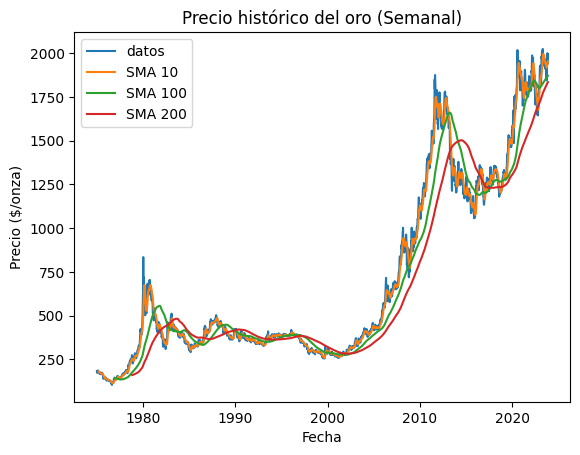

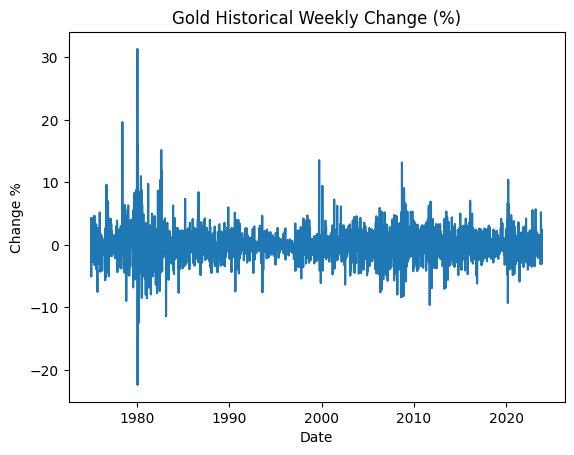

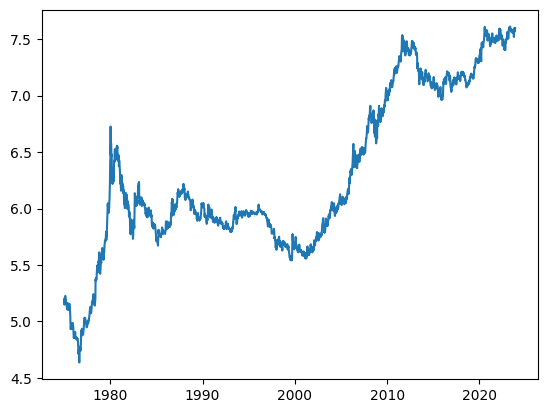

In [9]:
plt.figure(1)
plt.plot(gold_data['Date'],gold_data['Price'],label='datos')
plt.plot(gold_data['Date'][:-9],gold_MA_10,label='SMA 10')
plt.plot(gold_data['Date'][:-99],gold_MA_100,label='SMA 100')
plt.plot(gold_data['Date'][:-199],gold_MA_200,label='SMA 200')
plt.xlabel('Date')
plt.ylabel('Price ($/once)')
plt.legend()
plt.title('Gold historical price (Weeks)')
plt.figure(2)
plt.plot(gold_data['Date'],gold_data['Change %'])
plt.xlabel('Date')
plt.ylabel('Change %')
plt.title('Gold Historical Weekly Change (%)')


plt.figure(3)
plt.plot(gold_data['Date'],np.log(gold_data['Price']))
plt.xlabel('Date')
plt.ylabel('Price ($/once)')
plt.title('Logarithm of historical gold price (Weeks)')

[1.19700874e-04 5.00933362e+00]


Text(0.5, 1.0, 'Residuos tras eliminar la tendencia')

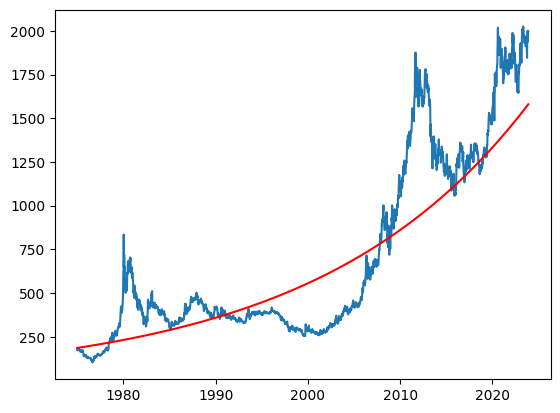

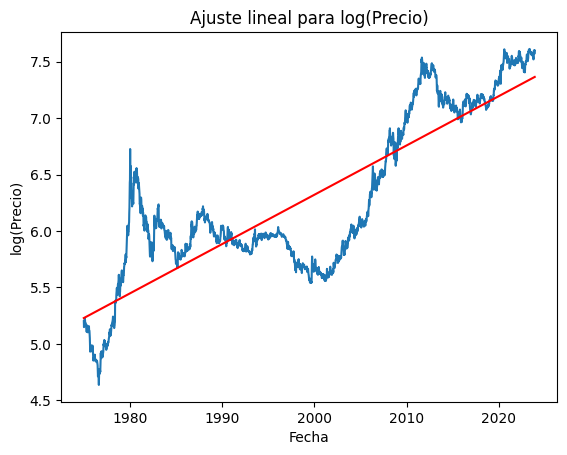

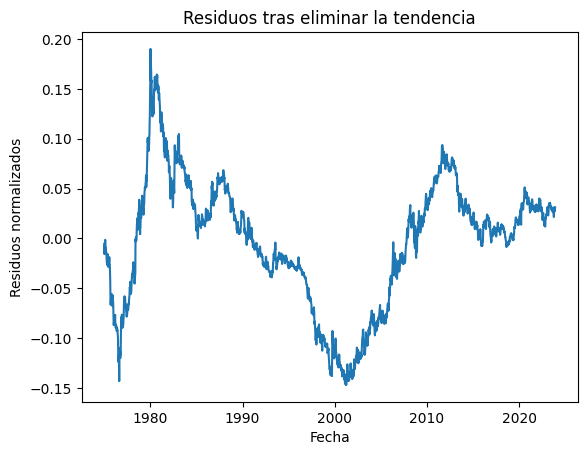

In [10]:
#Linear fit to the logarithm:
t = mdates.date2num(gold_data['Date'])
def ajuste(t,a,b):
    return a*t + b
def ajuste_real(t,a,b):
    return np.exp(a*t+b)
popt,pcov = curve_fit(ajuste,xdata=t,ydata=np.log(gold_data['Price']))
print(popt)
plt.figure()
plt.plot(gold_data['Date'],(gold_data['Price']),label='Price')
plt.plot(gold_data['Date'],ajuste_real(t,*popt),'r-',label='exp fit')
plt.xlabel('Date')
plt.ylabel('Price ($/once)')
plt.title('Historical gold price (Weeks)')
plt.legend()
plt.figure(4)
plt.plot(gold_data['Date'],np.log(gold_data['Price']),label='log(Price)')
plt.plot(gold_data['Date'],ajuste(t,*popt),'r-',label='linear fit')
plt.xlabel('Date')
plt.ylabel('log(Price)')
plt.title('Linear fit for log(Precio)')

#Residuals:
residuals = ((np.log(gold_data['Price']))-ajuste(t,*popt))/((np.log(gold_data['Price'])))
plt.figure(5)
plt.plot(gold_data['Date'],residuals)
plt.ylabel('Normalized residuals')
plt.xlabel('Date')
plt.title('Residuals after subtracting the subyacent tendency')

/tmp/ipykernel_247/1725218414.py:20: RuntimeWarning: divide by zero encountered in divide
  t_week = (1/f_oneside)/(60*60*24*7)


(0.0, 20.0)

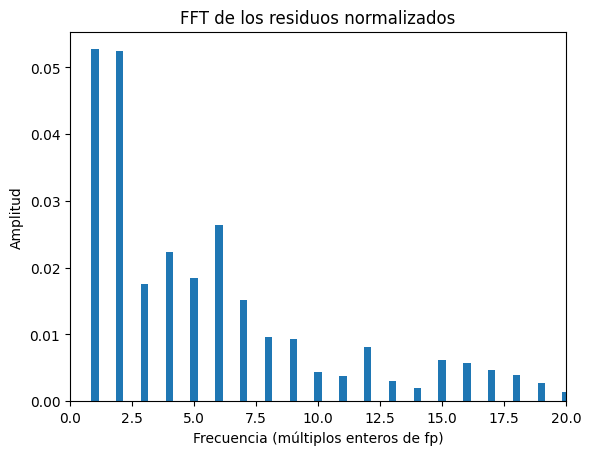

In [11]:
#Residuals FFT:
n_res,t_res,G_res,f_res = my_fft_week(residuals)
plt.figure(6)
plt.bar(f_res[1:]*Tot,np.abs(G_res[1:n_res])/n_res,width=0.3)
plt.xlabel('Frecuencia (múltiplos enteros de fp)')
plt.ylabel('Amplitud')
plt.title('FFT de los residuos normalizados')
plt.xlim(0,20)


#It tends to favor low frequencies (Long cycles)

In [12]:
Tot

1548892800

Text(0, 0.5, 'Valor de la diferencia')

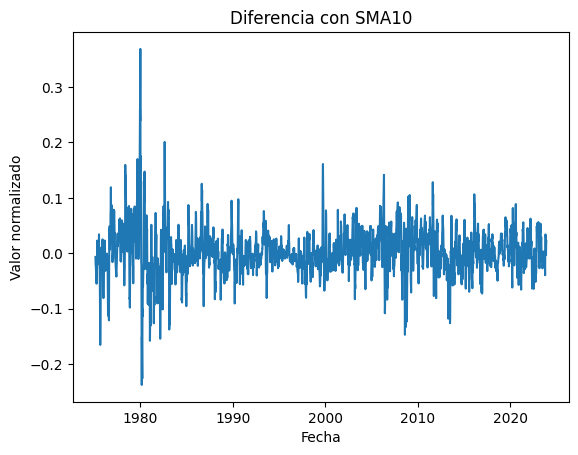

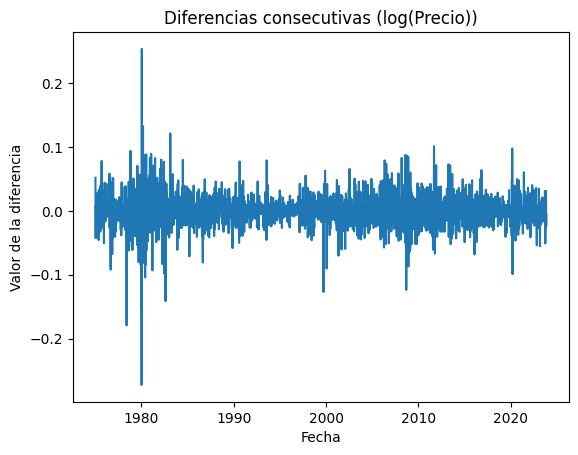

In [13]:
#SMA10 and consecutive differences method.
gold_data['log Price'] = gold_data['Price'].apply(lambda x: np.log(x))
dif10 = (gold_data['Price'][:-9] - gold_MA_10)/(gold_data['Price'][:-9]) #Normalized

gold_data['log Difference'] = (gold_data['log Price'] - gold_data['log Price'].shift())
plt.plot(gold_data['Date'][:-9],dif10)
plt.title('Difference with SMA10')
plt.xlabel('Date')
plt.ylabel('Normalized value')
plt.figure()
plt.plot(gold_data['Date'],gold_data['log Difference'])
plt.title('Consecutive differences (log(Price))')
plt.xlabel('Date')
plt.ylabel('Difference')

/tmp/ipykernel_247/1725218414.py:20: RuntimeWarning: divide by zero encountered in divide
  t_week = (1/f_oneside)/(60*60*24*7)


Text(0.5, 0, 'Frecuencia (múltiplos de fp)')

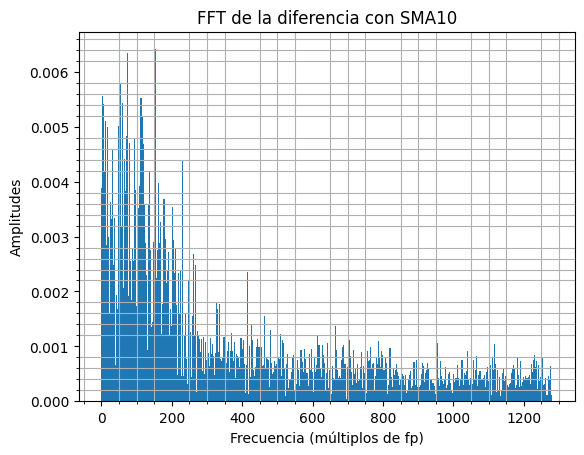

In [29]:
#FFT of price differences with SMA10.
n_dif,t_dif,G_dif,f_dif = my_fft_week(dif10)
plt.figure(10)
plt.bar(f_dif[1:]*Tot,np.abs(np.imag(G_dif[1:n_dif]))/n_dif,width=3)
plt.grid(which='minor')
plt.minorticks_on()
plt.title('FFT of price differences with SMA10')
plt.ylabel('Amplitudes')
plt.xlabel('Frequency (multiples of fp)')

/tmp/ipykernel_247/1725218414.py:20: RuntimeWarning: divide by zero encountered in divide
  t_week = (1/f_oneside)/(60*60*24*7)


Text(0, 0.5, 'Amplitudes')

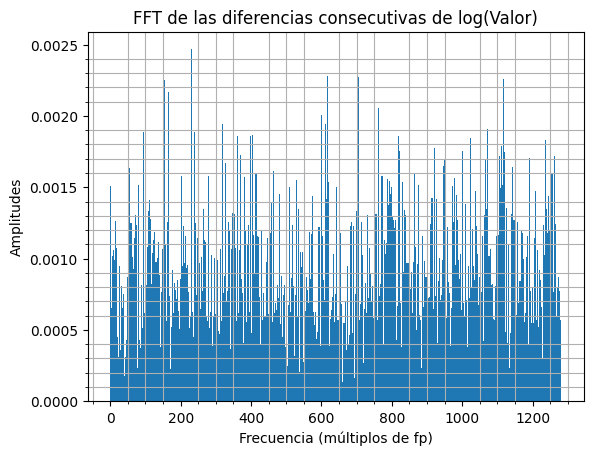

In [27]:
#FFT of consecutive differences
n_diflog,t_diflog,G_diflog,f_diflog = my_fft_week(gold_data['log Difference'])
plt.figure(10)
plt.bar(f_diflog[1:]*Tot,np.abs(np.imag(G_diflog[1:n_diflog]))/n_diflog,width=3)
plt.grid(which='minor')
plt.minorticks_on()
plt.title('FFT of consecutive differences for log(Price)')
plt.xlabel('Frequency (multiples of fp)')
plt.ylabel('Amplitudes')
